In [ ]:
emergency = {"cvae": "C://Users//nikol//MT-repo//logs//eval//runs//2025-11-15_22-01-55//baseline_cvae_rerun_test//latent_embeddings//latents_generated.csv",
             "TF-decoder": "C://Users//nikol//MT-repo//logs//eval//runs//2025-11-15_17-32-17//baseline_cvae_rerun_test//latent_embeddings//latents_generated.csv",
             "real": "C://Users//nikol//MT-repo//logs//eval//runs//2025-11-15_17-32-17//baseline_cvae_rerun_test//latent_embeddings//latents_train.csv",
             "TF-decoder-beam": "C://Users//nikol//MT-repo//logs//train//runs//2025-11-14_21-18-42//baseline_cvae_rerun_test//latent_embeddings//latents_generated.csv"
             }


sepsis = {"cvae": "C://Users//nikol//MT-repo//logs//eval//runs//2025-11-14_18-28-04//baseline_cvae_rerun_test//latent_embeddings//latents_generated.csv",
             "TF-decoder": "C://Users//nikol//MT-repo//logs//eval//runs//2025-11-14_18-48-50//baseline_cvae_rerun_test//latent_embeddings//latents_generated.csv",
             "real": "C://Users//nikol//MT-repo//logs//eval//runs//2025-11-14_18-28-04//baseline_cvae_rerun_test//latent_embeddings//latents_train.csv",
             "TF-decoder-beam": "C://Users//nikol//MT-repo//logs//eval//runs//2025-11-14_18-58-29//baseline_cvae_rerun_test//latent_embeddings//latents_generated.csv"
             }

bpic2012 = {"cvae": "C://Users//nikol//MT-repo//logs//eval//runs//2025-11-14_19-22-24//baseline_cvae_rerun_test//latent_embeddings//latents_generated.csv",
             "TF-decoder": "C://Users//nikol//MT-repo//logs//eval//runs//2025-11-14_19-27-17//baseline_cvae_rerun_test//latent_embeddings//latents_generated.csv",
             "real": "C://Users//nikol//MT-repo//logs//eval//runs//2025-11-14_19-22-24//baseline_cvae_rerun_test//latent_embeddings//latents_train.csv",
             "TF-decoder-beam": "C://Users//nikol//MT-repo//logs//eval//runs//2025-11-14_19-36-39//baseline_cvae_rerun_test//latent_embeddings//latents_generated.csv"
             }


data = bpic2012
dataset_name = "BPIC2012"

c:\Users\nikol\.conda\envs\mt-thesis-project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved figure to: ../output/BPIC2012\trace_space_BPIC2012.pdf


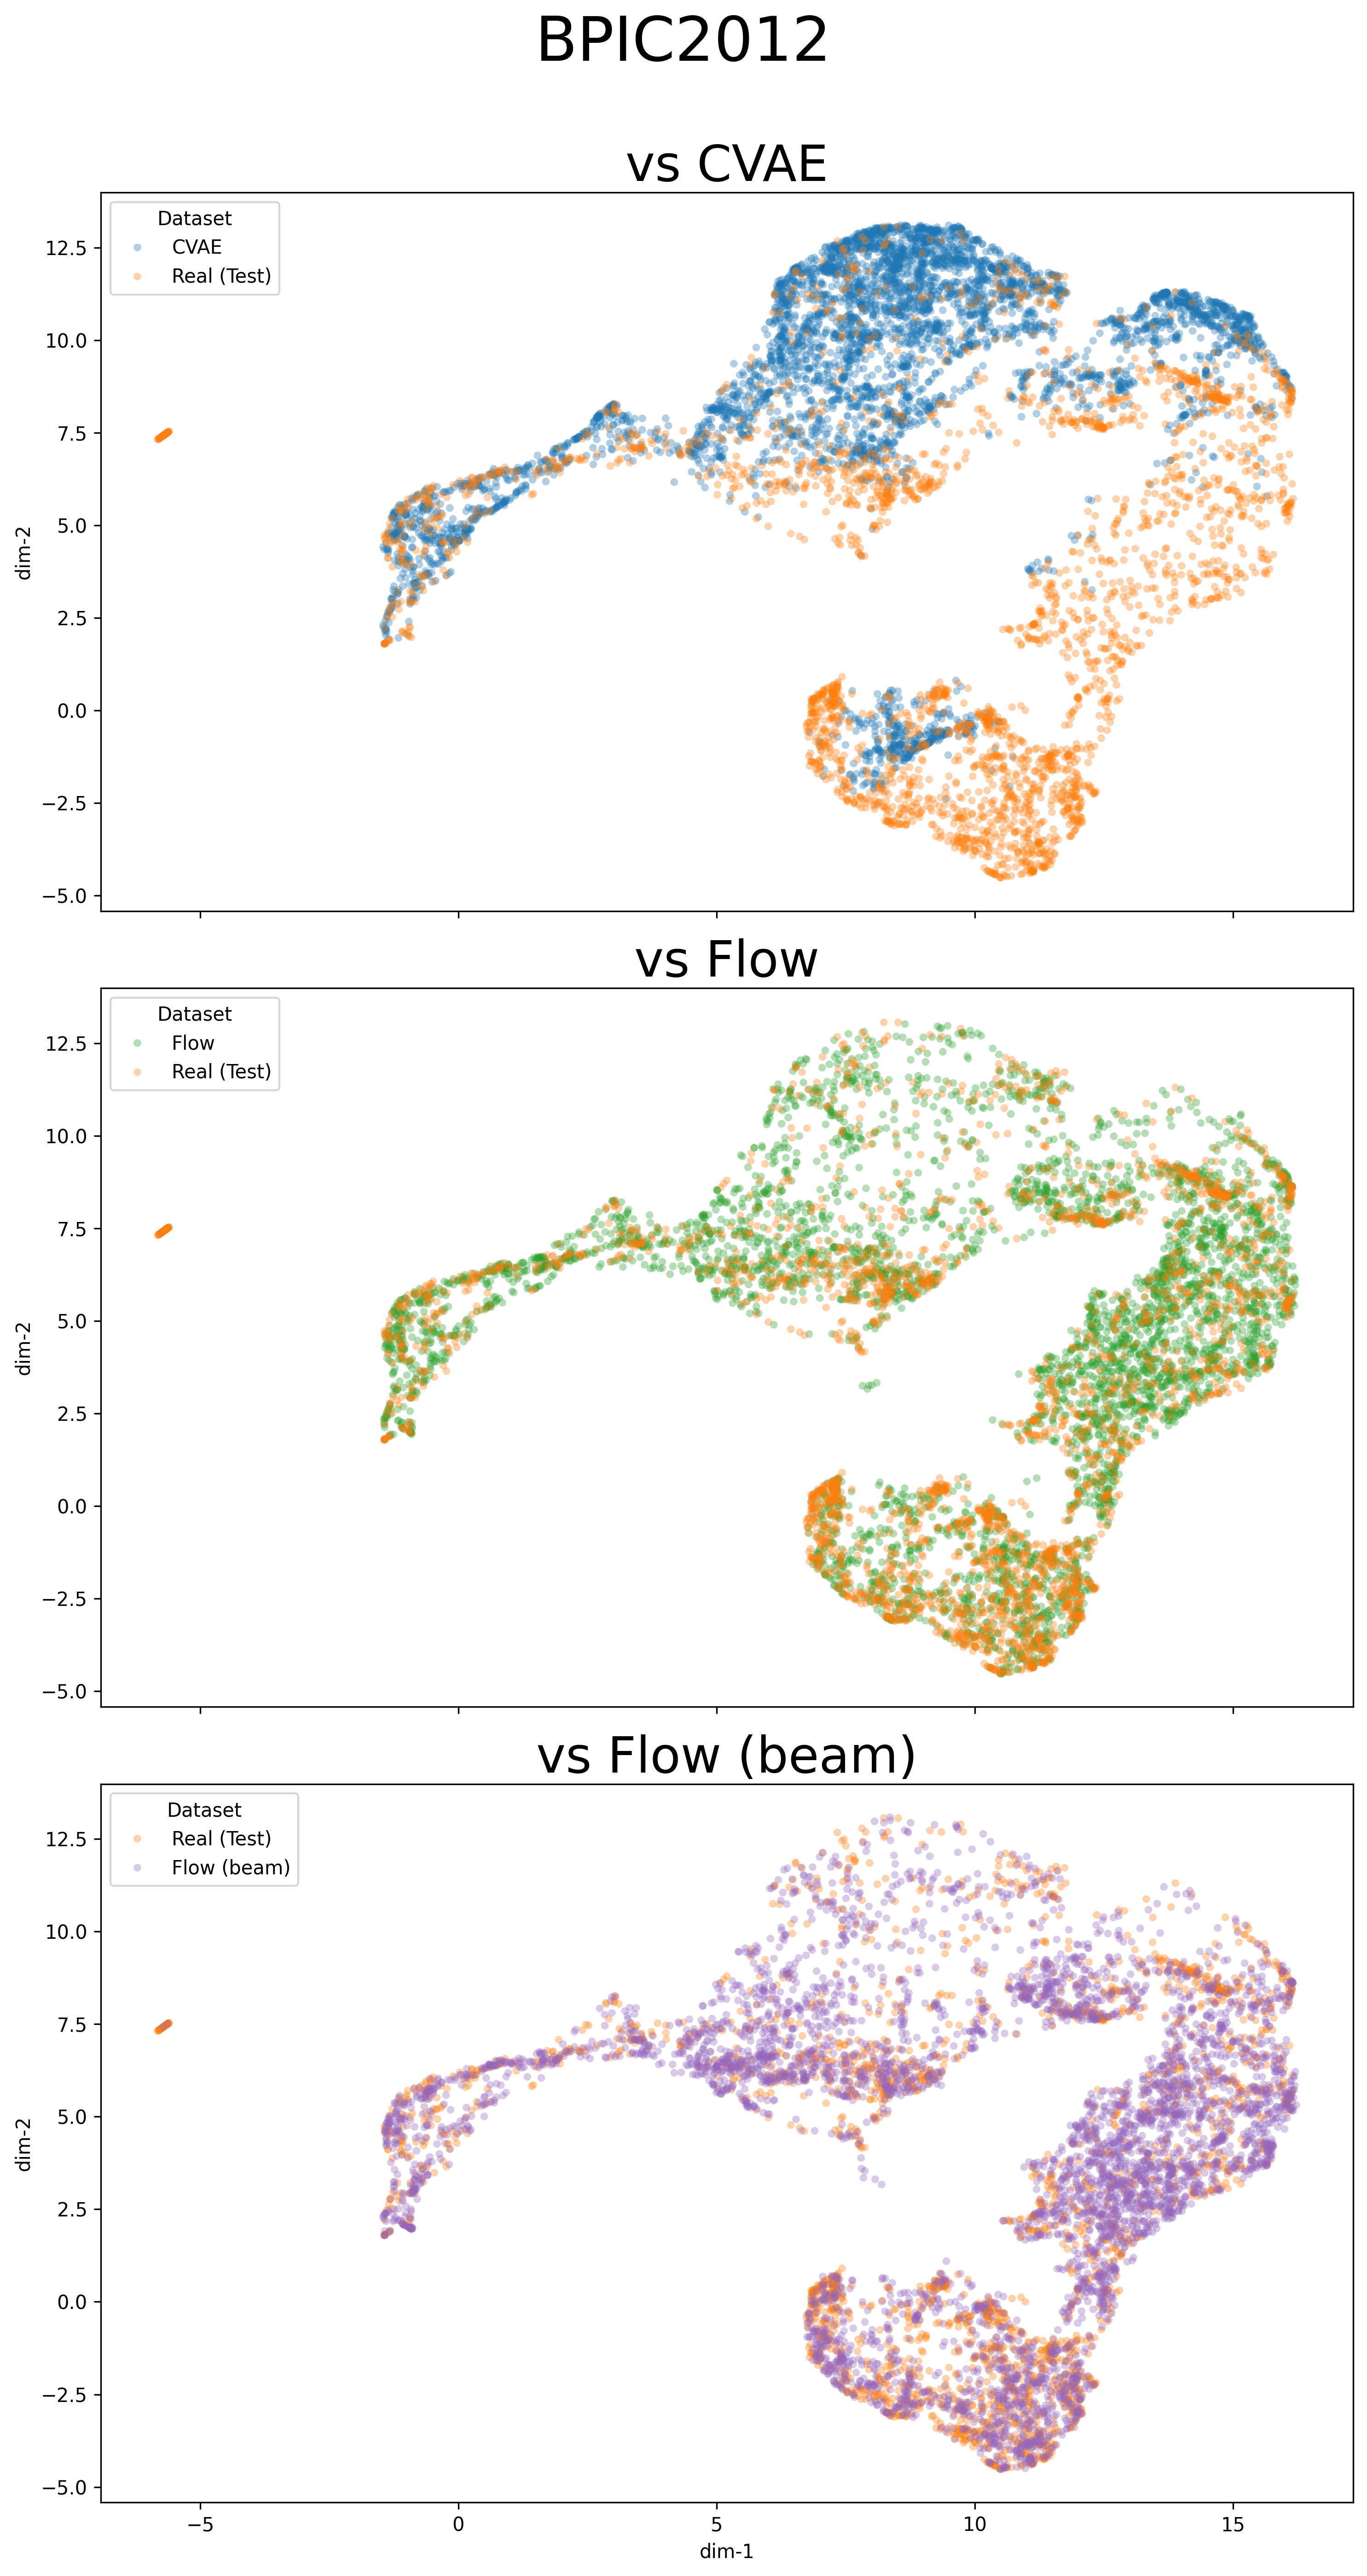

{'cvae_rows': 5000, 'flow_rows': 5000, 'flow_beam_rows': 5000, 'real_rows': 2811, 'latent_dim': 10, 'embedding_method': 'UMAP'}


In [8]:
# Load latent CSVs from sources and visualize with stacked scatter plots: Real vs CVAE, Real vs Flow, Real vs Flow Beam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Robust UMAP import handling
_HAS_UMAP = False
try:
    from umap import UMAP
    _HAS_UMAP = True
except Exception:
    try:
        import umap.umap_ as umap_module
        UMAP = umap_module.UMAP
        _HAS_UMAP = True
    except Exception:
        _HAS_UMAP = False

# ----------------------------------------------------------------------------
# 1) Read latent CSVs (paths defined in cell 1)
# ----------------------------------------------------------------------------
lat_cvae_gen = pd.read_csv(data['cvae'])          # CVAE generated
lat_flow_gen = pd.read_csv(data['TF-decoder'])    # Flow model generated
lat_real = pd.read_csv(data['real'])              # Real test latents
lat_flow_beam_gen = pd.read_csv(data['TF-decoder-beam'])  # Flow beam generated

# Determine dataset name for title


# Identify latent columns (means) based on CVAE file
mean_cols = sorted([c for c in lat_cvae_gen.columns if c.startswith('mean_')], key=lambda s: int(s.split('_')[1]))

# Sanity checks: ensure other sources share same mean columns
for df_name, df_ref in [('Flow', lat_flow_gen), ('Real', lat_real), ('Flow Beam', lat_flow_beam_gen)]:
    other_means = [c for c in df_ref.columns if c.startswith('mean_')]
    if set(other_means) != set(mean_cols):
        raise ValueError(f"{df_name} latent CSV does not share the same mean_* columns as CVAE generated.")

# ----------------------------------------------------------------------------
# 2) Optional downsampling for speed/clarity
# ----------------------------------------------------------------------------
SAMPLE_N = 5000
def _sample(df):
    return df.sample(SAMPLE_N, random_state=42) if len(df) > SAMPLE_N else df
lat_cvae_gen = _sample(lat_cvae_gen)
lat_flow_gen = _sample(lat_flow_gen)
lat_real = _sample(lat_real)
lat_flow_beam_gen = _sample(lat_flow_beam_gen)

# ----------------------------------------------------------------------------
# 3) Label datasets and combine
# ----------------------------------------------------------------------------
lat_cvae_gen['dataset'] = 'CVAE'
lat_flow_gen['dataset'] = 'Flow'
lat_real['dataset'] = 'Real (Test)'
lat_flow_beam_gen['dataset'] = 'Flow (beam)'

combined = pd.concat([lat_cvae_gen, lat_flow_gen, lat_real, lat_flow_beam_gen], ignore_index=True)
X = combined[mean_cols].to_numpy(dtype=float)

# ----------------------------------------------------------------------------
# 4) Dimensionality reduction to 2D (shared embedding for all plots)
# ----------------------------------------------------------------------------
if _HAS_UMAP:
    reducer = UMAP(n_components=2, n_neighbors=20, min_dist=0.1, random_state=42)
    Z = reducer.fit_transform(X)
else:
    try:
        reducer = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
        Z = reducer.fit_transform(X)
    except Exception:
        reducer = PCA(n_components=2)
        Z = reducer.fit_transform(X)

combined['x'] = Z[:, 0]
combined['y'] = Z[:, 1]

# ----------------------------------------------------------------------------
# 5) Stacked scatter plots (always 3)
# ----------------------------------------------------------------------------
palette = {
    'CVAE': '#1f77b4',
    'Flow': '#2ca02c',
    'Flow (beam)': '#9467bd',
    'Real (Test)': '#ff7f0e'
}

pair1 = combined[combined['dataset'].isin(['Real (Test)', 'CVAE'])]
pair2 = combined[combined['dataset'].isin(['Real (Test)', 'Flow'])]
pair3 = combined[combined['dataset'].isin(['Real (Test)', 'Flow (beam)'])]

fig, axes = plt.subplots(3, 1, figsize=(10, 20), dpi=300, sharex=True, sharey=True)
axes = np.atleast_1d(axes)

# Figure-level title (increased font size)
fig.suptitle(f"{dataset_name}", fontsize=32, y=0.95)

sns.scatterplot(data=pair1, x='x', y='y', hue='dataset', palette=palette, alpha=0.35, s=16, linewidth=0, ax=axes[0])
axes[0].set_title('vs CVAE', fontsize=26)
axes[0].set_xlabel('dim-1')
axes[0].set_ylabel('dim-2')
axes[0].legend(title='Dataset', loc='best')

sns.scatterplot(data=pair2, x='x', y='y', hue='dataset', palette=palette, alpha=0.35, s=16, linewidth=0, ax=axes[1])
axes[1].set_title('vs Flow', fontsize=26)
axes[1].set_xlabel('dim-1')
axes[1].set_ylabel('dim-2')
axes[1].legend(title='Dataset', loc='best')

sns.scatterplot(data=pair3, x='x', y='y', hue='dataset', palette=palette, alpha=0.35, s=16, linewidth=0, ax=axes[2])
axes[2].set_title('vs Flow (beam)', fontsize=26)
axes[2].set_xlabel('dim-1')
axes[2].set_ylabel('dim-2')
axes[2].legend(title='Dataset', loc='best')

# Tight layout with small top margin reserved for suptitle
plt.tight_layout(rect=[0, 0.02, 1, 0.94])

# ----------------------------------------------------------------------------
# 5b) Save figure as PDF
# ----------------------------------------------------------------------------
out_dir = f"../output/{dataset_name}"
os.makedirs(out_dir, exist_ok=True)
pdf_path = os.path.join(out_dir, f'trace_space_{dataset_name.upper()}.pdf')
fig.savefig(pdf_path, format='pdf', bbox_inches='tight')
print(f"Saved figure to: {pdf_path}")

plt.show()

# ----------------------------------------------------------------------------
# 6) Per-source basic stats
# ----------------------------------------------------------------------------
summary = {
    'cvae_rows': int((combined['dataset'] == 'CVAE').sum()),
    'flow_rows': int((combined['dataset'] == 'Flow').sum()),
    'flow_beam_rows': int((combined['dataset'] == 'Flow (beam)').sum()),
    'real_rows': int((combined['dataset'] == 'Real (Test)').sum()),
    'latent_dim': len(mean_cols),
    'embedding_method': 'UMAP' if _HAS_UMAP else ('TSNE' if isinstance(reducer, TSNE) else 'PCA')
}
print(summary)


In [9]:
# Three separate figures: one per dataset with a single row of model comparisons
multi_datasets = [
    ("EMERGENCY", EMERGENCY),
    ("SEPSIS", SEPSIS),
    ("BPIC2012", BPIC)
]
model_columns = [
    ("CVAE", 'cvae'),
    ("Flow", 'TF-decoder'),
    ("Flow (beam)", 'TF-decoder-beam')
]
palette_multi = {
    'CVAE': '#1f77b4',
    'Flow': '#2ca02c',
    'Flow (beam)': '#9467bd',
    'Real (Test)': '#ff7f0e'
}

for dataset_label, dataset_paths in multi_datasets:
    latents = {
        'CVAE': pd.read_csv(dataset_paths['cvae']),
        'Flow': pd.read_csv(dataset_paths['TF-decoder']),
        'Flow (beam)': pd.read_csv(dataset_paths['TF-decoder-beam']),
        'Real (Test)': pd.read_csv(dataset_paths['real'])
    }

    mean_cols = sorted([c for c in latents['CVAE'].columns if c.startswith('mean_')], key=lambda s: int(s.split('_')[1]))
    for name, df in latents.items():
        df = _sample(df).copy()
        df['dataset'] = name
        latents[name] = df

    for check_key in ['Flow', 'Flow (beam)', 'Real (Test)']:
        other_means = [c for c in latents[check_key].columns if c.startswith('mean_')]
        if set(other_means) != set(mean_cols):
            raise ValueError(f"{dataset_label} -> {check_key} latent CSV mismatch in mean_* columns.")

    combined = pd.concat(latents.values(), ignore_index=True)
    X = combined[mean_cols].to_numpy(dtype=float)

    if _HAS_UMAP:
        reducer = UMAP(n_components=2, n_neighbors=20, min_dist=0.1, random_state=42)
        Z = reducer.fit_transform(X)
    else:
        try:
            reducer = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
            Z = reducer.fit_transform(X)
        except Exception:
            reducer = PCA(n_components=2)
            Z = reducer.fit_transform(X)

    combined['x'] = Z[:, 0]
    combined['y'] = Z[:, 1]

    fig, axes = plt.subplots(1, len(model_columns), figsize=(20, 6), dpi=400, sharex=True, sharey=True)
    axes = np.atleast_1d(axes)
    fig.suptitle(dataset_label, fontsize=24, y=1.02)

    for ax, (model_label, _) in zip(axes, model_columns):
        pair_df = combined[combined['dataset'].isin(['Real (Test)', model_label])]
        sns.scatterplot(
            data=pair_df,
            x='x',
            y='y',
            hue='dataset',
            palette=palette_multi,
            alpha=0.35,
            s=14,
            linewidth=0,
            ax=ax
        )
        ax.set_title(f"vs {model_label}", fontsize=20)
        ax.set_xlabel('dim-1')
        ax.set_ylabel('dim-2')

    # Keep only the legend on the last axis for clarity
    for ax in axes[:-1]:
        leg = ax.get_legend()
        if leg:
            leg.remove()
    axes[-1].legend(title='Dataset', loc='best')

    plt.tight_layout()
    plt.show()

NameError: name 'EMERGENCY' is not defined